# Neural score estimation

This tutorial demonstrates how to perform neural score estimation (NSE) with `lampe`.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NSE, NSELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep

## Simulator

In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([ 0.7184, -0.5701,  0.9329])
tensor([0.1875, 0.5891])


In [3]:
loader = JointLoader(prior, simulator, batch_size=256, vectorized=True)

## Training

The principle of neural score estimation (NSE) is to train a regression network $s_\phi(\theta, x, t)$ to match the score of a stochastic diffusion process over the parameters $\theta$. We use the [`NSE`](lampe.inference.NSE) class provided by the [`lampe.inference`](lampe.inference) module to create a regression network adapted to the simulator's input and output sizes.

In [4]:
estimator = NSE(3, 2, hidden_features=[64] * 5, activation=nn.ELU)
estimator

NSE(
  (net): MLP(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=64, out_features=3, bias=True)
  )
)

Then, we train our regressor using a standard neural network training routine.

In [5]:
loss = NSELoss(estimator)
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 128)
step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping

estimator.train()

with tqdm(range(128), unit='epoch') as tq:
    for epoch in tq:
        losses = torch.stack([
            step(loss(theta, x))
            for theta, x in islice(loader, 256)  # 256 batches per epoch
        ])

        tq.set_postfix(loss=losses.mean().item())

        scheduler.step()

100%|██████████| 128/128 [01:02<00:00,  2.06epoch/s, loss=0.149]


## Inference

Now that we have an estimator of the score, we can solve the probability flow ODE to sample from the posterior $p_\phi(\theta | x)$. For convenience, the `flow` method of the `NSE` class returns a conditional distribution which can be sampled from.

In [6]:
theta_star = prior.sample()
x_star = simulator(theta_star)

estimator.eval()

with torch.no_grad():
    samples = estimator.flow(x_star).sample((2**16,))

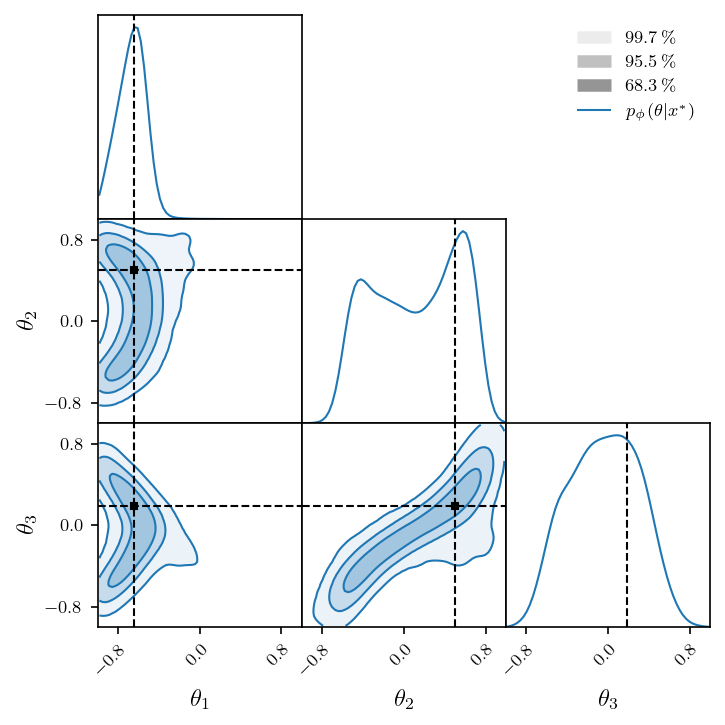

In [7]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, theta_star)

The `log_prob` method of the distribution returned by `flow` is a stochastic estimator of the true log-density. Therefore, one should average over a sufficient number of evaluations to attain small errors.

In [8]:
with torch.no_grad():
    log_p = estimator.flow(x_star).log_prob(theta_star.expand(1024, -1))

mu = log_p.mean().item()
sigma = log_p.std() / 1024 ** 0.5

print(f'{mu:.4f} ± {sigma:.4f}')

3.6841 ± 0.1945
